In [1]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Trapz                             # Integral Numérica

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

In [2]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end
function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end
function utrapz(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return trapz(xval, yval)*yunit*xunit
end 
function fwhm(x, y)
    maxy = maximum(y)
    n1 = findfirst(a -> a>maxy/2, y)
    n2 = findlast(a -> a>maxy/2, y)
    return x[n2]-x[n1]
end

power(x, y) = utrapz(x, abs.(y).^2)

normalize(x, Ax, y, Ay) = Ay*sqrt(power(x, Ax)/power(y, Ay))

normalize (generic function with 1 method)

In [3]:
N = 1024

P0 = 1u"mW"
T0 = 25u"ps"

λ = 1550u"nm"
α = uconvertp(NoUnits,0.02u"dB")*u"km^-1"
D = 6u"ps/(nm*km)"
γ = 1.8u"W^(-1)*km^(-1)"

β2 = -λ^2*D/(2π*c) |> u"ps^2/km"

-7.652689196969962 ps^2 km^-1

In [4]:
z = range(0u"km", 400u"km", N)
h = z[2]-z[1]

LD = T0^2/abs(β2)
P0 = 1/(γ*LD)
LNL = 1/(γ*P0) |> u"km"

Tf = sqrt(1+z[end]^2/LD^2)*T0

t = range(-1000u"ps", 1000u"ps", N)
Δf = 1/(t[2]-t[1]) |> u"GHz"
f = fftfreq(N, Δf) |> fftshift;

At = zeros(N,N)*(0.0+im*0.0)*u"sqrt(mW)";
Af = zeros(N,N)*(0.0+im*0.0)*u"sqrt(mW*ps/GHz)";

T0 = 41.05571847507331 ps
B0 = 6.993164062499858 GHz


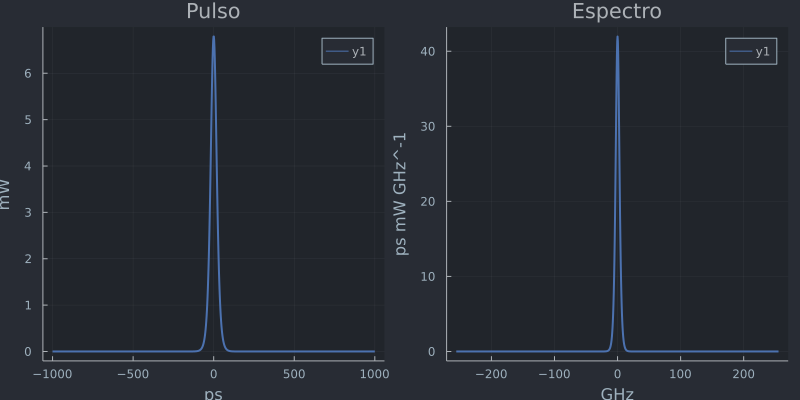

In [5]:
At[1,:] = sqrt(P0)*sech.(t/T0)
Af[1,:] = normalize(t, At[1,:], f, ufft(At[1,:]) |> fftshift)

p1 = plot(t, abs.(At[1,:]).^2, title="Pulso")
p2 = plot(f, abs.(Af[1,:]).^2, title="Espectro")
println("T0 = $(fwhm(t,abs.(At[1,:]).^2))\nB0 = $(fwhm(f,abs.(Af[1,:]).^2))")
plot(p1, p2)

In [6]:
A_spm(At) = At .* exp.(im*γ*abs.(At).^2*h)
A_gvd(Af) = Af .* exp.(im*β2/2*(2π*f).^2*h)

function split_step(N_op, D_op)
    for i in 2:N
        AfD = D_op(Af[i-1,:])
        AtD = normalize(f, AfD, t, uifft(AfD))
        AtN = N_op(AtD) 
        
        Af[i,:] = normalize(t, AtN, f, ufft(AtN))
        At[i,:] = AtN 
    end
end

split_step (generic function with 1 method)

In [7]:
split_step(A_spm, A_gvd)

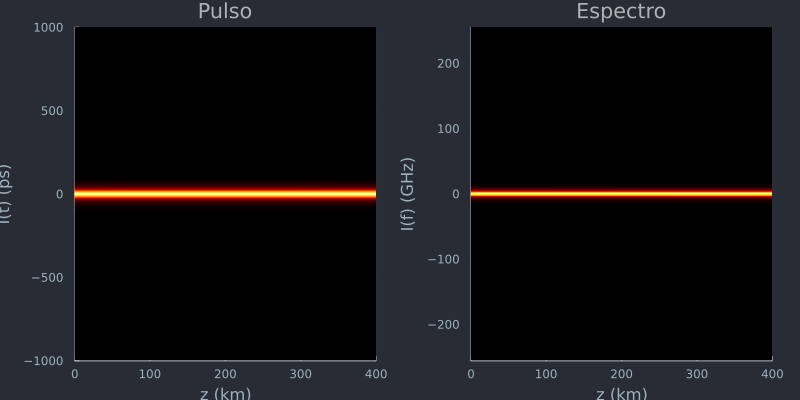

In [8]:
function heatmap_pulse(z, t, At, f, Af)
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log) |> display
end

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_EuxdoZ.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_EuxdoZ.gif")
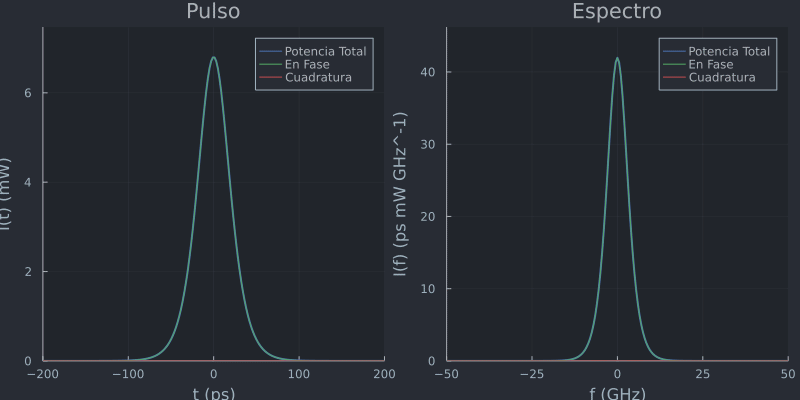

In [9]:
function animate_pulse(At, Af, tlims, flims)
    ylimsf = (0*unit(Af[1])^2, maximum(abs.(Af).^2)).*1.1
    ylimst = (0*unit(At[1])^2, maximum(abs.(At).^2)).*1.1
    
    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2, linewidth=2, xlims=flims, ylims=ylimsf, label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

        p1 = plot(t, abs.(At[i,:]).^2, linewidth=2, xlims=tlims, ylims=ylimst, label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(At, Af, (-200, 200).*u"ps", (-50, 50).*u"GHz")

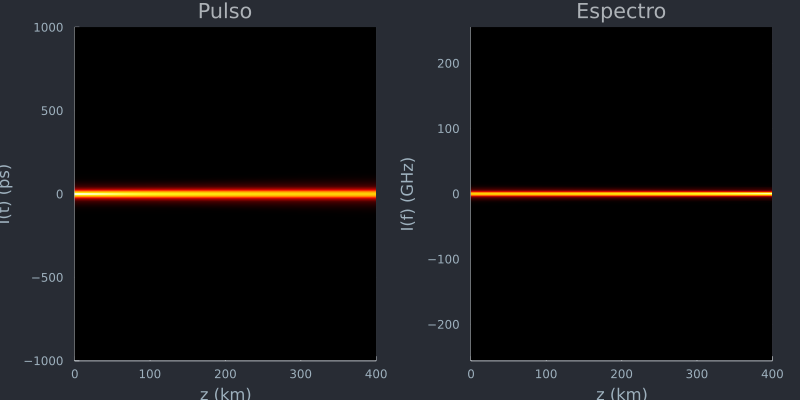

In [10]:
At[1,:] = sqrt(0.9*P0)*sech.(t/T0)
Af[1,:] = normalize(t, At[1,:], f, ufft(At[1,:]) |> fftshift)

split_step(A_spm, A_gvd)

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_3966Yc.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_3966Yc.gif")
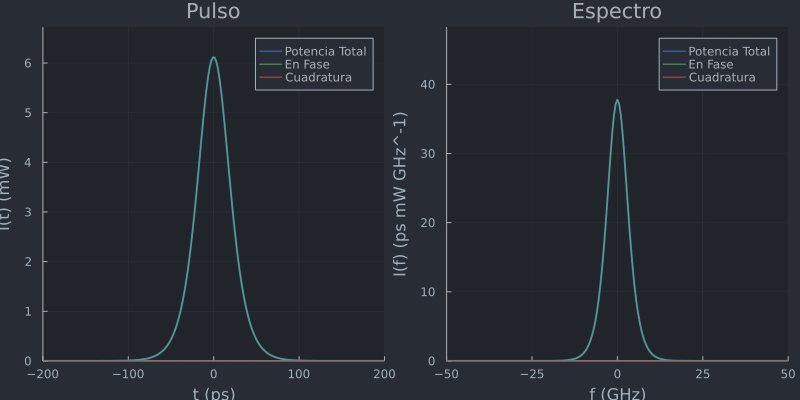

In [11]:
animate_pulse(At, Af, (-200, 200).*u"ps", (-50, 50).*u"GHz")

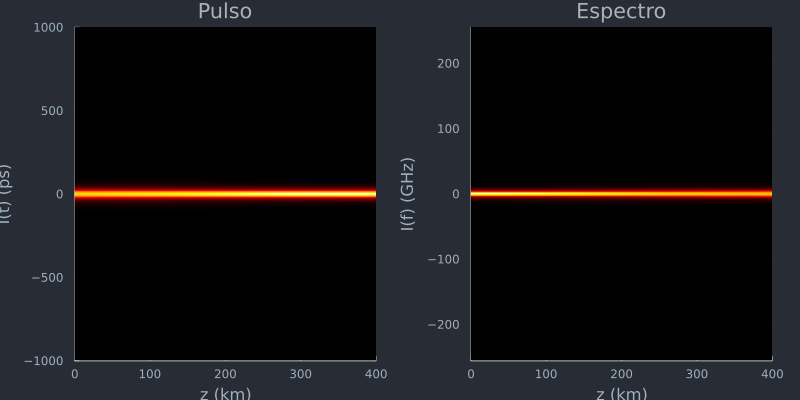

In [12]:
At[1,:] = sqrt(1.1*P0)*sech.(t/T0)
Af[1,:] = normalize(t, At[1,:], f, ufft(At[1,:]) |> fftshift)

split_step(A_spm, A_gvd)

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_p0NsYd.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_p0NsYd.gif")
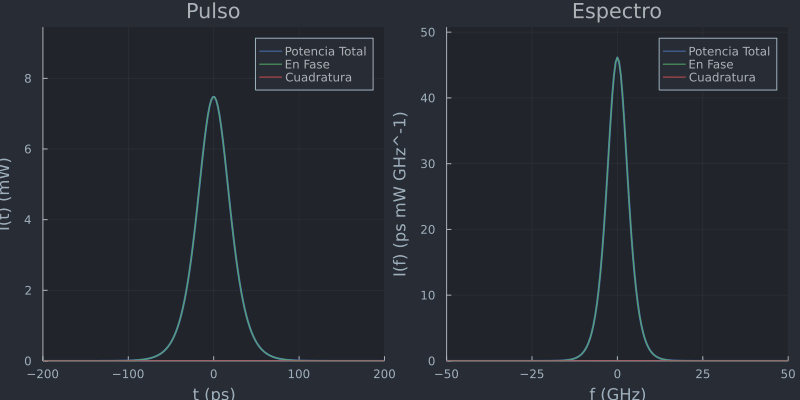

In [13]:
animate_pulse(At, Af, (-200, 200).*u"ps", (-50, 50).*u"GHz")